## Training Evaluation
Look at results of training

In [1]:
# imports
import os, sys
import json
from datetime import date
import random

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

sys.path.insert(1, os.path.abspath(".."))
sys.path.insert(1, os.path.abspath(os.path.join('..', 'pytv')))
from pytv.engine import train_one_epoch, evaluate
import pytv.utils as utils

from data import MaskRCNNDataset
from train import make_new_maskr, load_checkpoint

# basic setup torch device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using cuda")
else:
    device = torch.device("cpu")
    pring("using cpu")

using cuda


In [2]:
# script parameters
DATA_PATH = os.path.join("..", "..", "supp", "testkc")
CKPT_PATH = os.path.join("..", "mrcnn_2021-08-23")

In [3]:
# setup datasets
dta_trn = MaskRCNNDataset(DATA_PATH, "train", None)
train_data = torch.utils.data.DataLoader(dta_trn, batch_size=2, shuffle=True,
                                        num_workers=1, collate_fn=utils.collate_fn)
dta_tst = MaskRCNNDataset(DATA_PATH, "test", None)
test_data = torch.utils.data.DataLoader(dta_tst, batch_size=2, shuffle=False,
                                       num_workers=1, collate_fn=utils.collate_fn)

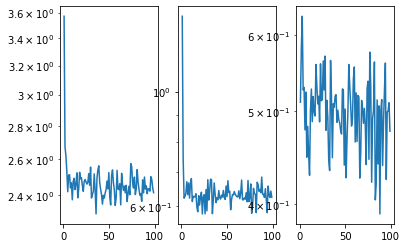

In [4]:
# load training script arguments and losses
with open(os.path.join(CKPT_PATH, "args.json")) as args_json:
    train_args = json.load(args_json)
losses = pd.read_csv(os.path.join(CKPT_PATH, "losses.csv"))
loss_top = losses.head()
loss_top
plt.subplot(1, 3, 1)
plt.semilogy(losses.index[1:], losses["loss"][1:])
plt.subplot(1, 3, 2)
plt.semilogy(losses.index[1:], losses["loss_mask"][1:])
plt.subplot(1, 3, 3)
plt.semilogy(losses.index[1:], losses["loss_objectness"][1:])

In [5]:
net, _, _ = load_checkpoint(os.path.join(CKPT_PATH, "model.pth"), train_args)

In [6]:
# do prediction on test dataset
img, tar = next(iter(test_data))
net.eval()
pred = net(img)

/home/mb46/.conda/envs/pyt/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


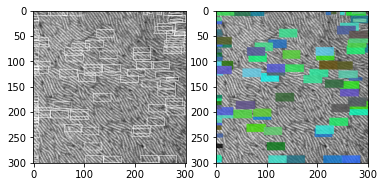

In [11]:
# look at predictions

# formulate display image as uint8 RGB
i_disp = (img[0] * 255).byte()
i_disp = torch.cat((i_disp, i_disp, i_disp), dim=0)
# draw bounding box
bb = pred[0]['boxes']
bb_img = draw_bounding_boxes(i_disp, pred[0]['boxes'])
# draw segmentation masks
sg_img = draw_segmentation_masks(i_disp, pred[0]['masks'].squeeze().bool())
plt.subplot(1, 2, 1)
plt.imshow(torch.swapaxes(bb_img, 0, 2).numpy())
plt.subplot(1, 2, 2)
plt.imshow(torch.swapaxes(sg_img, 0, 2).numpy())